## Detection of Malicious Accounts on Azure-AD signon using Relational Graph Neural Network (RGCN)

### Content
1. Introduction
2. Dataset Loading & Processing
3. Graph Construction
4. Model Training
5. Evaluation
6. Summary

### 1. Introduction

Azure active directory (Azure-AD) is an identity and access management service, that helps users to access external and internal resources such as Office365, SaaS applications. The Sign-in logs in Azure-AD log identifies who the user is, how the application is used for the access and the target accessed by the identity [[1]](https://docs.microsoft.com/en-us/azure/active-directory/reports-monitoring/concept-sign-ins). On a given time 𝑡, a service 𝑠 is requested by user 𝑢 from device 𝑑 using authentication mechanism of 𝑎 to be either allowed or blocked. For in detail explanation refer the following page of the [Microsoft azure-sign-in](https://docs.microsoft.com/en-us/azure/active-directory/reports-monitoring/concept-sign-ins)

Similar works on anomalous authentication detection includes applying blackbox ML models on handcrafted features extracted from authentication logs or rule-based models. This workflow closely follows on the success of heterogenous GNN embedding on cyber application such as, fraud detection [[2](https://doi.org/10.1145/3269206.3272010),[5](https://www.vldb.org/pvldb/vol15/p427-rao.pdf)], cyber-attack detection on prevalence dataset [[3](http://arxiv.org/abs/2112.08986)]. Unlike earlier models, this work uses heterogenous graph for authentication graph modeling and relational GNN embedding for capturing relations among different entities. This allows us to take advantage of relations among users/services, and at the same time avoids feature extracting phase. At the end the model learns both from structural identity and unique feature identity of individual users. 

The main motivation behind this work is to tackle the drawbacks of rule-based or feature based system, such as failure to generalize for new attacks and the requirements for dynamic rules that need to be maintained often. An evolving attack and connected malicious users across the network are hard to detect through feature/rule-based methods. Additionally, using graph approach minimizes efforts on feature engineering tasks.

This workflow shows end-to-end pipeline for azure malicious sign-in malicious detection using heterogenous relational graph neural network (RGCN).

In [44]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F
import dgl.nn.pytorch as dglnn
from utils import *
from sklearn.metrics import roc_auc_score, accuracy_score
from model import HeteroRGCN
from tqdm import trange
from data_processing import   build_azure_graph,  synthetic_azure

from utils import get_metrics
from model_training import init_loaders, train, evaluate, save_model, load_model
torch.manual_seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



### Dataset Loading and Processing
Load dataset and set true fraud label for the testing and status flag for training. Define set of meta columns to exclude as training features. 

In [45]:
status_label = 'status_flag'
result_dir = 'azure_result'


meta_cols = ['day','appId', 'userId', 'ipAddress',
            'fraud_label','appId_id','userId_id','ipAddress_id', 'auth_id', 'status_flag']

train_data, test_data, train_idx, test_idx, labels, df  = synthetic_azure('../dataset/azure_synthetic/azure_ad_logs_sample_with_anomaly_all.json')

fraud_labels = df['fraud_label'].values


In [46]:
print('The distribution of status flag for the train data is:\n', train_data['status_flag'].value_counts())
print('The distribution of fraud for the test data is:\n', test_data['fraud_label'].value_counts())

The distribution of status flag for the train data is:
 0    1584
1     408
Name: status_flag, dtype: int64
The distribution of fraud for the test data is:
 0.0    146
1.0     89
Name: fraud_label, dtype: int64


In [47]:
print(f"Days in test set {test_data.day.unique().tolist()}")

Days in test set [243, 242]


In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Graph Construction

Construct training and inference graph. Each graph is constructed using `train_data` and `test_data`, with graph schema defined in the `build_azure_graph` method. Create feature and compute weight for training proportion.

![Azure-graph](graph.png)

In [49]:
g, _ = build_azure_graph(train_data, meta_cols)
g_test, feature_tensors = build_azure_graph(df, meta_cols)
n_nodes = sum([g.number_of_nodes(n_type) for n_type in g.ntypes])
n_edges = sum([g.number_of_edges(e_type) for e_type in g.etypes])

In [50]:
# hyperparameters
in_size, hidden_size, out_size, n_layers, embedding_size = feature_tensors.shape[1], 16, 2, 2, 8  # 2 16
target_node = "authentication"
hyperparameters = {"in_size":in_size, "hidden_size":hidden_size, "out_size":out_size,
                   "n_layers":n_layers, "embedding_size":embedding_size, "target_node":target_node}
labels = torch.LongTensor(labels).to(device)
scale_pos_weight = train_data[status_label].sum() / train_data.shape[0]
scale_pos_weight = torch.tensor(
    [scale_pos_weight, 1-scale_pos_weight]).to(device)



### Model Training

#### RGCN Model

At high level, the RGCN model takes graph 𝐺 of nodes features 𝑋 and learn an embedding of 𝐺 with a function 𝑓:𝑉→𝑅𝑑 that map each node 𝑣∈ 𝑉 to d-dimensional vector [[4]](https://arxiv.org/abs/1703.06103). The model is trained as a semi-supervised settings to classify each authentication as potential success or failure authentication from historical authentication logs. The embedding vector for “authentication” node is then used to score whether the authentication is benign or malicious. We compare the detection score of RGCN SoftMax layer along feeding the learned embedding to unsupervised anomaly detection algorithm isolation forest.

In [51]:
print(
    """ ---- Data statistics ------
            # Nodes: {}
            # Edges: {}
            # Features Shape: {}
            # Labeled Train samples: {}
            # Unlabeled Test samples: {}""".
    format(
        n_nodes, n_edges, feature_tensors.shape[0],
        train_data.shape[0],
        test_data.shape[0]))

 ---- Data statistics ------
            # Nodes: 2375
            # Edges: 11952
            # Features Shape: 2227
            # Labeled Train samples: 1992
            # Unlabeled Test samples: 235


#### Training

The model is trained using synthetic azure log data of selected users and tested on future days of the azure logs. Selected features are aggregated as OHE per day for individual users, app requested, and device activity logs and authentication behaviors. 

The following features are converted as OHE features of **authentication** node features 
```python
['deviceDetail.trustType', 'riskState','riskLevelAggregated','riskLevelDuringSignIn','clientAppUsed','deviceDetail.operatingSystem']
```

Then the OHE features along other features are aggregated based on the following groups  
```python 
group_by = ['appId', 'userId', 'ipAddress', 'day']
``` 
with the following aggregation function 
```python
agg_func = {
        'location.city': 'nunique',
        'location.countryOrRegion': 'nunique',
        'resourceDisplayName': 'nunique',
        'fraud_label': 'max',
        'deviceDetail.isCompliant': 'sum',
        'deviceDetail.isManaged': 'sum',
        'riskDetail': 'sum',
        'status_flag': 'max'} 
```
  
For all OHE features ```sum``` aggregation is used. This to capture the aggregated behavior patter of a user entities with combinination of the `device`, `service` across selected time span. The final aggregated features are set as ``authentication` node features, for all other nodes the graph is initialized with dummy features.


The `statusFlag` indicates whether an azure authentication results into success or failure due to azure risk scores. This verify which authentication is allowed or blocked due to several reason [1]. When authentication results to failure, azure-AD reports failure reason and error code associated with the failure. Due to scarcity of real malicious authentication events, we propse to use statusFlag as indicator of authentication that need to be blocked or allowed. 

Using historical log data, for semi-supervised training we employ the `statusFlag` feature for training the RGCN model to either allow or block an authentication. As a result the model is trained to block events that looks failure cases due to several reason, which a malicious authentication is subset of authentication under "failure" category. For training set we convert all `statusFlag` into binary feature of "success" and "failure" cases. 

Set dataloaders, define model and optimizers.

In [52]:
epochs = 30
train_loader, val_loader, test_loader = init_loaders(
    g, train_idx, test_idx=test_idx, val_idx=train_idx, g_test=g_test,
    target_node=target_node)

model = HeteroRGCN(g, in_size, hidden_size, out_size,
                   n_layers, embedding_size, device=device, target=target_node).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001, weight_decay=5e-4)
loss_func = nn.CrossEntropyLoss(weight=scale_pos_weight.float())
best_model = model

In [53]:
best_auc = 0
for epoch in trange(epochs):
    train_acc, loss = train(
        model, loss_func, train_loader, labels, optimizer, feature_tensors,
        target_node=target_node, device=device)
    print("Epoch {:03d}/{:03d} | Train Accuracy: {:.4f} | Train Loss: {:.4f}".format(
        epoch, epochs, train_acc, loss))

    val_logits, val_seed, _ = evaluate(
        model, val_loader, feature_tensors, target_node, device=device)
    val_accuracy = accuracy_score(
        val_logits.argmax(1),
        labels.long()[val_seed].cpu()).item()
    val_auc = roc_auc_score(labels.long()[val_seed].cpu().numpy(),
                            val_logits[:, 1].numpy(),)
    print(
        "Validation Accuracy: {:.4f} auc {:.4f}".format(
            val_accuracy, val_auc))
        
best_model = model

  7%|▋         | 2/30 [00:00<00:02, 13.86it/s]

Epoch 000/030 | Train Accuracy: 0.5746 | Train Loss: 1.3770
Validation Accuracy: 0.6913 auc 0.5604
Epoch 001/030 | Train Accuracy: 0.6613 | Train Loss: 1.3622
Validation Accuracy: 0.7786 auc 0.6232
Epoch 002/030 | Train Accuracy: 0.7379 | Train Loss: 1.3479
Validation Accuracy: 0.8183 auc 0.6797
Epoch 003/030 | Train Accuracy: 0.7520 | Train Loss: 1.3337


 20%|██        | 6/30 [00:00<00:01, 14.68it/s]

Validation Accuracy: 0.8238 auc 0.7276
Epoch 004/030 | Train Accuracy: 0.7651 | Train Loss: 1.3194
Validation Accuracy: 0.8283 auc 0.7587
Epoch 005/030 | Train Accuracy: 0.7722 | Train Loss: 1.3050
Validation Accuracy: 0.8343 auc 0.7771
Epoch 006/030 | Train Accuracy: 0.7692 | Train Loss: 1.2902
Validation Accuracy: 0.8308 auc 0.7879


 33%|███▎      | 10/30 [00:00<00:01, 14.73it/s]

Epoch 007/030 | Train Accuracy: 0.7722 | Train Loss: 1.2750
Validation Accuracy: 0.8414 auc 0.7940
Epoch 008/030 | Train Accuracy: 0.7712 | Train Loss: 1.2593
Validation Accuracy: 0.8609 auc 0.7982
Epoch 009/030 | Train Accuracy: 0.7974 | Train Loss: 1.2435
Validation Accuracy: 0.8604 auc 0.7997


 40%|████      | 12/30 [00:00<00:01, 14.74it/s]

Epoch 010/030 | Train Accuracy: 0.7974 | Train Loss: 1.2272
Validation Accuracy: 0.8604 auc 0.8046
Epoch 011/030 | Train Accuracy: 0.8266 | Train Loss: 1.2102
Validation Accuracy: 0.8745 auc 0.8151
Epoch 012/030 | Train Accuracy: 0.8286 | Train Loss: 1.1930
Validation Accuracy: 0.8735 auc 0.8231


 53%|█████▎    | 16/30 [00:01<00:00, 14.65it/s]

Epoch 013/030 | Train Accuracy: 0.8256 | Train Loss: 1.1753
Validation Accuracy: 0.8665 auc 0.8248
Epoch 014/030 | Train Accuracy: 0.8135 | Train Loss: 1.1573
Validation Accuracy: 0.8579 auc 0.8265
Epoch 015/030 | Train Accuracy: 0.8135 | Train Loss: 1.1391
Validation Accuracy: 0.8579 auc 0.8284


 60%|██████    | 18/30 [00:01<00:00, 14.62it/s]

Epoch 016/030 | Train Accuracy: 0.8135 | Train Loss: 1.1206
Validation Accuracy: 0.8564 auc 0.8299
Epoch 017/030 | Train Accuracy: 0.8135 | Train Loss: 1.1020
Validation Accuracy: 0.8630 auc 0.8309
Epoch 018/030 | Train Accuracy: 0.8095 | Train Loss: 1.0834
Validation Accuracy: 0.8544 auc 0.8324


 73%|███████▎  | 22/30 [00:01<00:00, 14.68it/s]

Epoch 019/030 | Train Accuracy: 0.8095 | Train Loss: 1.0648
Validation Accuracy: 0.8464 auc 0.8345
Epoch 020/030 | Train Accuracy: 0.8095 | Train Loss: 1.0464
Validation Accuracy: 0.8464 auc 0.8367
Epoch 021/030 | Train Accuracy: 0.8095 | Train Loss: 1.0281
Validation Accuracy: 0.8474 auc 0.8384


 80%|████████  | 24/30 [00:01<00:00, 14.68it/s]

Epoch 022/030 | Train Accuracy: 0.8115 | Train Loss: 1.0101
Validation Accuracy: 0.8564 auc 0.8404
Epoch 023/030 | Train Accuracy: 0.8145 | Train Loss: 0.9923
Validation Accuracy: 0.8529 auc 0.8428
Epoch 024/030 | Train Accuracy: 0.8105 | Train Loss: 0.9749
Validation Accuracy: 0.8504 auc 0.8463


 93%|█████████▎| 28/30 [00:01<00:00, 14.73it/s]

Epoch 025/030 | Train Accuracy: 0.8266 | Train Loss: 0.9578
Validation Accuracy: 0.8559 auc 0.8516
Epoch 026/030 | Train Accuracy: 0.8256 | Train Loss: 0.9414
Validation Accuracy: 0.8559 auc 0.8549
Epoch 027/030 | Train Accuracy: 0.8236 | Train Loss: 0.9257
Validation Accuracy: 0.8549 auc 0.8601


100%|██████████| 30/30 [00:02<00:00, 14.66it/s]

Epoch 028/030 | Train Accuracy: 0.8236 | Train Loss: 0.9106
Validation Accuracy: 0.8534 auc 0.8642
Epoch 029/030 | Train Accuracy: 0.8246 | Train Loss: 0.8964
Validation Accuracy: 0.8539 auc 0.8690


Save model, hyperparameters and graph structure.

In [71]:
# Save model
save_model(g, model, hyperparameters, "../modeldir/")

In [72]:
# Load the model for inference
model_new, g_ = load_model("../modeldir/")

### Evaluation

For evaluation and comparing we need to create the "authentication" embedding from the training and test dataset. 

In [56]:
## Create training & test embedding
train_logits, train_seeds, train_embedding = evaluate(
    best_model, train_loader, feature_tensors, target_node)

In [57]:
test_logits, test_seeds, test_embedding = evaluate(
    best_model, test_loader, feature_tensors, target_node)

In the synthetic test data there is one account with malicious attack authentication for the last day of the event. To test the model performance, we set all events by the attacker account as fraudulent login for the last day and measure AUC and accuracy for all the event in the last two days.

In [68]:
test_acc = accuracy_score(
    test_logits.argmax(dim=1),
    labels.long()[test_seeds].cpu()).item()
test_auc = roc_auc_score(fraud_labels[test_seeds],
                         test_logits[:, 1].numpy())
print(f"AUC: {test_auc} and Accuracy: {test_acc}")

AUC: 0.7582730490995844 and Accuracy: 0.8468085106382979


The `train_logit` and `test_logits` are the output of the RGCN classification layer. We can evaluate the model using `test_logits` along evaluation label. The `train_embedding` and `test_embedding` dataframe consists of an embedding of the authentication. These embedding
can be used to train & evaluate for other baseline models, such as XGBoost or unsupervised model (Isoltion Forest).

Further we compare the performance against other baseline models on test data that include malicious authentication events. There are four models compared. 

1. RGCN: This the proposed model with binary output from the final softmax layer of the RGCN model.
2. RGCN_IF: This model takes authentication embedding from RGCN and feed IsolationForest with authentication embedding.
3. If_OHE: Baseline IsolationForest trained with preprocessed features & OHE of few cardinality categorical features.
4. XGB_OHE: Similar to IF_OHE with XGBoost used for training on raw features for binary predictions using `statusFlag` as label.

Following figure shows ROC curve of the four models on synthetic test data.

In [69]:
col_remove = meta_cols 
metrics_result = pd.DataFrame()
test_scores = test_data[meta_cols].copy()

print("Final Test Accuracy: {:.3f} auc {:.3f}".format(test_acc, test_auc))
# RGCN

test_scores['rgcn'] = test_logits.numpy()[:,1]

# XGBoost
_, _, _, _, _, _, _, _, pred_xgb, roc_xgg = baseline_models(
    train_x=train_data.drop(col_remove, axis=1), test_x=test_data.drop(col_remove, axis=1),
    train_idx=train_idx, test_idx=test_idx, labels=labels.cpu().numpy() ,
    test_label=fraud_labels, name='XGB')

test_scores['xgb'] = pred_xgb

# RGCN+XGBoost
_, _, _, _, _, _, _, _, pred_rgcn_xgb, _ = baseline_models(
    train_x=train_embedding.cpu().numpy(),
    test_x=test_embedding.cpu().numpy(), 
    train_idx=train_seeds,
    test_idx=test_seeds,
    labels=labels.cpu().numpy(),
    test_label=fraud_labels,
    name='RGCN+XGB')

test_scores['rgcn_xgb'] = pred_rgcn_xgb

# rgcn + iforest
_, _, _, _, _, _, _, _, pred_rgcn_if, roc_rgcniff = unsupervised_models(
    train_x=train_embedding.cpu().numpy(), test_x=test_embedding.cpu().numpy(), 
    train_idx=train_seeds, test_idx=test_seeds,
    labels=labels.cpu().numpy(),
    test_label=fraud_labels, name='RGCN_iforest')

test_scores['rgcn_if'] = pred_rgcn_if

#iforest+OHE
_, _, _, _, _, _, _, _, iff_scores,_ = unsupervised_models(
    train_x=train_data.drop(col_remove, axis=1), test_x=test_data.drop(col_remove, axis=1), 
    train_idx=train_data.index, test_idx=test_data.reset_index().index,
    labels=test_data.fraud_label,
    test_label=fraud_labels, name='iforest')

test_scores['if_OHE'] = iff_scores

Final Test Accuracy: 0.847 auc 0.758


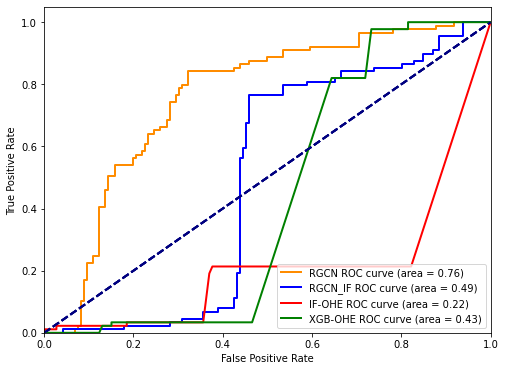

In [76]:
def roc_cr(fpr, tpr,  model_name='Model', color='darkorange'):
    
    lw = 2
    roc_auc = roc_auc_score(fpr, tpr)
    fpr, tpr, _ = roc_curve(fpr, tpr)
    
    plt.plot(fpr, tpr, color=color,
             lw=lw, label=model_name+' ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

f = plt.figure(figsize=(8,6))
roc_cr(test_scores.fraud_label, test_scores['rgcn'], model_name='RGCN')
roc_cr(test_scores.fraud_label, test_scores['rgcn_if'], color='blue', model_name='RGCN_IF')
roc_cr(test_scores.fraud_label, iff_scores, color='red', model_name='IF-OHE')
roc_cr(test_scores.fraud_label, pred_xgb, color='green', model_name='XGB-OHE')

In the simulated synthetic dataset, the malicious event authentication is due to the abnormal behavior of a single user. The proportion is a bit larger to resemble a typical authentication log. For a real azure-ad log we expect the attacker to behave in an indeterministic way, and the proportion of fraud relative to benign is quite small. 

Further, using the workflow we compare the models trained on an internal real azure-ad dataset of more than 45k events for training and 11k events for testing. The 'statusFlag' is used for training the mode and for testing known fraudulent events are used. Using these embeddings we compare the performance of RGCN based model against the baseline algorithm trained & tested on the authentication embedding. The following figure shows snapshot of AUC curve of the models.

![model comparison](model_comp.png)

In both dataset, we noticed the RGCN model is capturing important embedding information to identify the fraudulent login events compared to models trained using raw logs. It is noticable that the raw features (specially OHE) is little bit hard to work with the IForest or XGBoost, we think this could be the reason the baseline modesl performing badly compared to the RGCN type models.

### Conclusion

In this workflow, we showed end-to-end workflow for malicious azure detection using RGCN.
we explore methods of heterogeneous graph embedding for malicious sign-on detection of azure logs. This work adds two main contributions. First, adapting log authentication as GNN, allows us to learn a richer embedding of authentication on both structural and individual entities involved without much hand-crafted feature learning. Second, by modeling every “authentication” as a target node, the model avoids the challenge of depending on modeling temporal historical user login information. The experimental result  shows, RGCN prediction scores on authentication nodes have a promising result on overall detection performance and are better than the baseline isolation forest & XGBoost algorithm on the raw and encoded features.

### Reference
1. https://docs.microsoft.com/en-us/azure/active-directory/reports-monitoring/concept-sign-ins
2. Liu, Ziqi, et al. “Heterogeneous Graph Neural Networks for Malicious Account Detection.” arXiv [cs.LG], 27 Feb. 2020, https://doi.org/10.1145/3269206.3272010. arXiv.
3. Lv, Mingqi, et al. “A Heterogeneous Graph Learning Model for Cyber-Attack Detection.” arXiv [cs.CR], 16 Dec. 2021, http://arxiv.org/abs/2112.08986. arXiv.
4. Schlichtkrull, Michael, et al. "Modeling relational data with graph convolutional networks." European semantic web conference. Springer, Cham, 2018 https://arxiv.org/abs/1703.06103
5. Rao, Susie Xi, et al. "xFraud: explainable fraud transaction detection." Proceedings of the VLDB Endowment 3 (2021) https://www.vldb.org/pvldb/vol15/p427-rao.pdf
6. Powell, Brian A. "Detecting malicious logins as graph anomalies." Journal of Information Security and Applications 54 (2020): 102557 https://arxiv.org/abs/1909.09047